<a href="https://colab.research.google.com/github/Kritikargv17/Deep-Learning-LAB/blob/main/Exp7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SETUP ENVIRONMENT
!pip install torch torchvision matplotlib scikit-learn -q
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# CONFIG
SEED = 42
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Using device:", DEVICE)


Using device: cpu


In [ ]:
# DATASET AND DATALOADER
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Load MNIST dataset
train_val_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split train into train/val
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.39MB/s]


In [ ]:
# DEFINE CNN MODEL
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 7x7
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = CNN().to(DEVICE)
print(model)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)




In [ ]:
# TRAINING AND EVALUATION FUNCTIONS
def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_all, targets_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)
            preds_all.extend(logits.argmax(1).cpu().numpy())
            targets_all.extend(y.cpu().numpy())
    return total_loss/total, correct/total, np.array(preds_all), np.array(targets_all)

In [ ]:
 #RUN TRAINING
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, EPOCHS+1):
    tl, ta = train_epoch(model, train_loader)
    vl, va, _, _ = evaluate(model, val_loader)
    train_losses.append(tl); val_losses.append(vl)
    train_accs.append(ta); val_accs.append(va)
    print(f"Epoch {epoch}: Train acc={ta:.4f}, Val acc={va:.4f}")

Epoch 1: Train acc=0.9770, Val acc=0.9853
Epoch 2: Train acc=0.9848, Val acc=0.9863
Epoch 3: Train acc=0.9876, Val acc=0.9863
Epoch 4: Train acc=0.9908, Val acc=0.9885
Epoch 5: Train acc=0.9926, Val acc=0.9913
Epoch 6: Train acc=0.9929, Val acc=0.9898
Epoch 7: Train acc=0.9944, Val acc=0.9888
Epoch 8: Train acc=0.9940, Val acc=0.9903
Epoch 9: Train acc=0.9951, Val acc=0.9885
Epoch 10: Train acc=0.9960, Val acc=0.9907


In [ ]:
# TEST EVALUATION
test_loss, test_acc, test_preds, test_targets = evaluate(model, test_loader)
print(f"\n✅ Test accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(test_targets, test_preds, digits=4))


✅ Test accuracy: 0.9929

Classification Report:
               precision    recall  f1-score   support

           0     0.9939    0.9980    0.9959       980
           1     0.9956    0.9974    0.9965      1135
           2     0.9971    0.9903    0.9937      1032
           3     0.9931    0.9960    0.9946      1010
           4     0.9959    0.9888    0.9923       982
           5     0.9878    0.9966    0.9922       892
           6     0.9968    0.9875    0.9921       958
           7     0.9903    0.9903    0.9903      1028
           8     0.9918    0.9938    0.9928       974
           9     0.9862    0.9901    0.9881      1009

    accuracy                         0.9929     10000
   macro avg     0.9928    0.9929    0.9929     10000
weighted avg     0.9929    0.9929    0.9929     10000



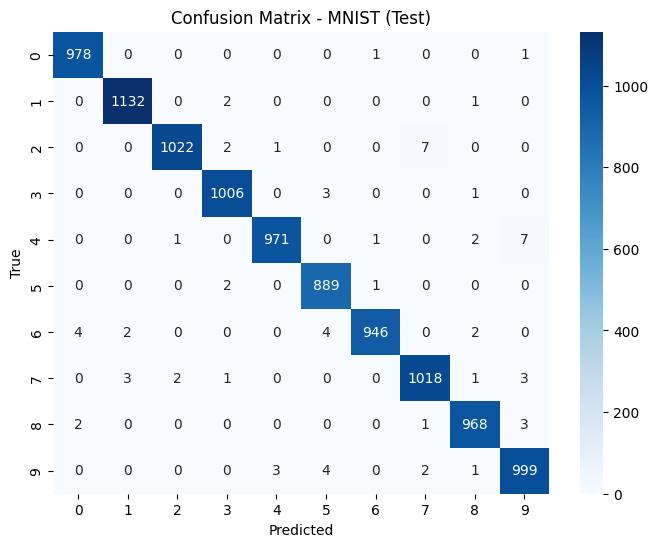

In [ ]:
# CONFUSION MATRIX
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MNIST (Test)")
plt.show()

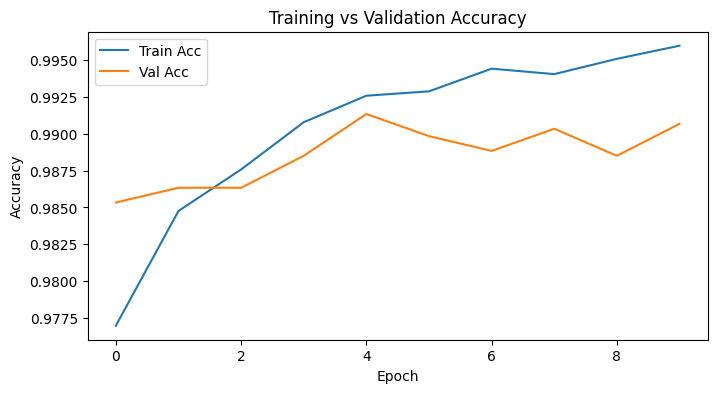

In [ ]:
# ACCURACY CURVES
plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

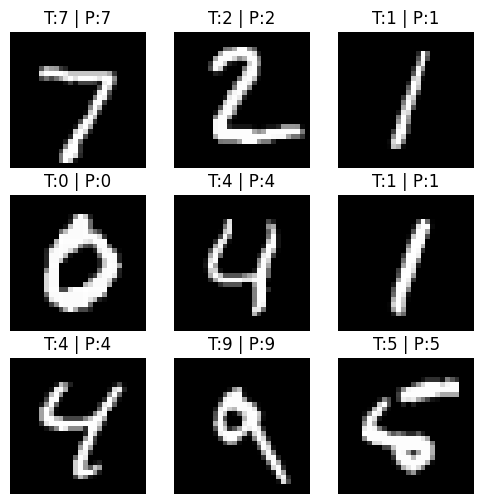

In [ ]:
#SAMPLE PREDICTIONS
images, labels = next(iter(test_loader))
images, labels = images[:9], labels[:9]

with torch.no_grad():
    outputs = model(images.to(DEVICE))
    preds = outputs.argmax(1).cpu()

fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i][0], cmap="gray")
    ax.set_title(f"T:{labels[i]} | P:{preds[i]}")
    ax.axis("off")
plt.show()